In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
pwd

'/content'

In [0]:
# https://github.com/umeshpalai/AlgorithmicTrading-MachineLearning #####   location of the csv files.

'/content'

In [0]:
dataset = pd.read_csv('/content/RELIANCE.NS.csv', index_col = 0)
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

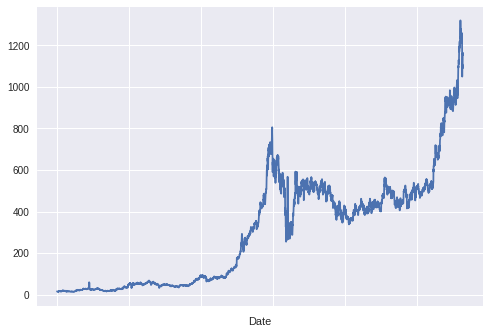

In [0]:
df_stock['Close'].plot()
plt.show()

In [0]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

In [0]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 30 
test_set_size_percentage = 30 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [0]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2249, 19, 4)
y_train.shape =  (2249, 4)
x_valid.shape =  (1686, 19, 4)
y_valid.shape =  (1686, 4)
x_test.shape =  (1686, 19, 4)
y_test.shape =  (1686, 4)


In [0]:
"""Building the Model"""

# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 3
learning_rate = 0.001
batch_size = 20
n_epochs = 50 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [0]:
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [0]:
#RNN 
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)] 

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last 

In [0]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [0]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.007969/0.185122
5.00 epochs: MSE train/valid = 0.000005/0.004554
10.00 epochs: MSE train/valid = 0.000003/0.002366
14.99 epochs: MSE train/valid = 0.000003/0.002064
19.99 epochs: MSE train/valid = 0.000002/0.001329
24.99 epochs: MSE train/valid = 0.000002/0.001367
29.99 epochs: MSE train/valid = 0.000001/0.000782
34.98 epochs: MSE train/valid = 0.000002/0.001075
39.98 epochs: MSE train/valid = 0.000002/0.001393
44.98 epochs: MSE train/valid = 0.000002/0.000429
49.98 epochs: MSE train/valid = 0.000001/0.000739


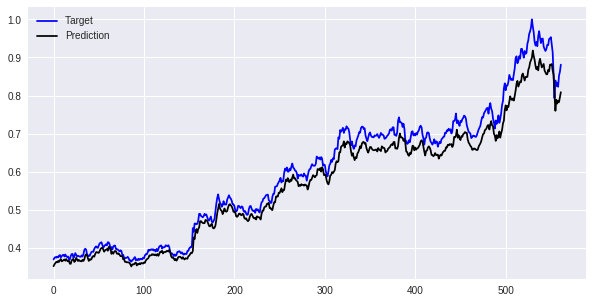

In [0]:
#checking prediction output nos 
y_test_pred.shape

# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

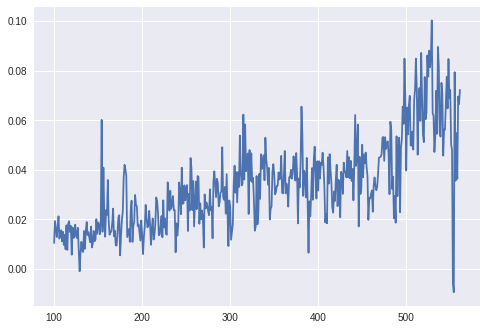

In [0]:
test  = comp['Column1'][100:]- comp['Column2'][100
                                               :]
test.plot()

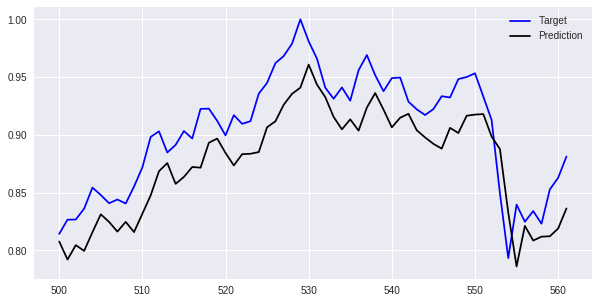

In [0]:
#checking prediction output nos 
y_test_pred.shape

# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'][500:], color='blue', label='Target')
plt.plot(comp['Column2'][500:], color='black', label='Prediction')
plt.legend()
plt.show()

In [0]:
comp.tail()

,Column1,Column2
557,0.834047,0.808521
558,0.823106,0.811892
559,0.852754,0.812231
560,0.862854,0.818941
561,0.881255,0.836315
